In [5]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# Simulation parameters
RUNS = 1
NETWORK_FILE = "./networks/network_15_6.pkl"
FILEPATH_CSV = "./sim_results/avg_rmse.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 500
q = 9.5e-5  # Process noise intensity
r = 5  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

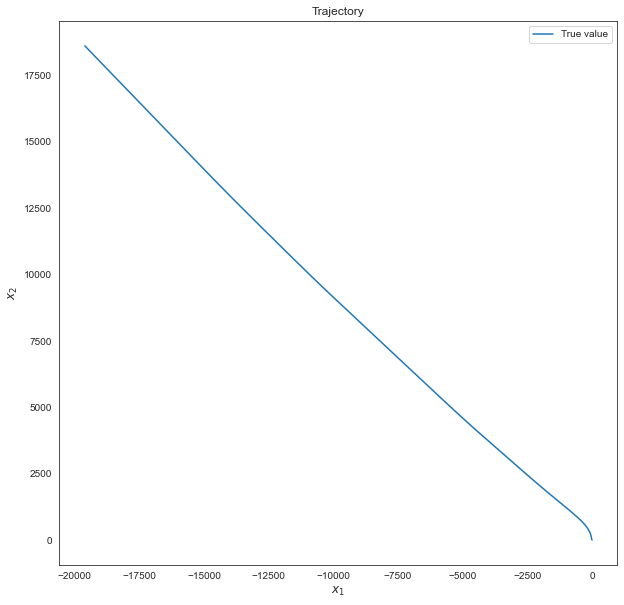

In [8]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [9]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(20 * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    # traj.simulate(ndat, INIT_STATE)
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

In [10]:
# kfn.draw_network()

In [11]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

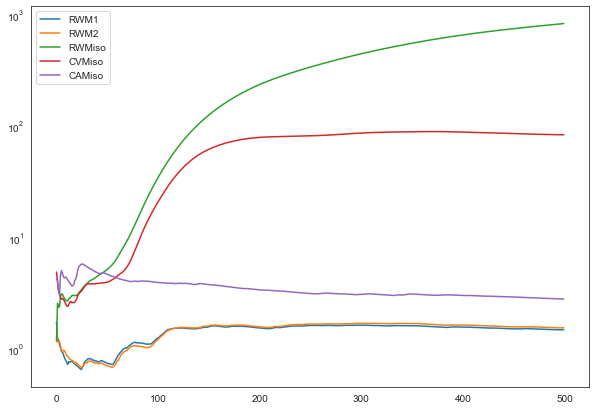

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 0], label="RWM1")
plt.plot(rmse_rwm2[:, 0], label="RWM2")

plt.plot(rmse_rwmnc[:, 0], label="RWMiso")
plt.plot(rmse_cvmnc[:, 0], label="CVMiso")
plt.plot(rmse_camnc[:, 0], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

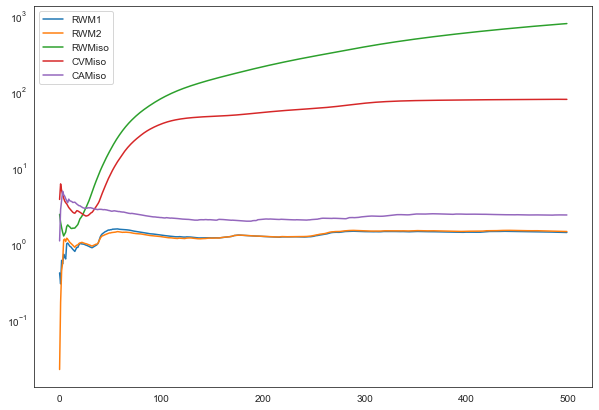

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 1], label="RWM1")
plt.plot(rmse_rwm2[:, 1], label="RWM2")

plt.plot(rmse_rwmnc[:, 1], label="RWMiso")
plt.plot(rmse_cvmnc[:, 1], label="CVMiso")
plt.plot(rmse_camnc[:, 1], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [14]:
# CSV column labels
cols = []
for n in chain(kfn._txt_labels, ["RWM_NC", "CVM_NC", "CAM_NC"]):
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

data = rmse_network(kfn, traj, ndat, 2, rwmnc, cvmnc, camnc)

In [15]:
# Generate CSV files
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_1_x1,RWM_1_x2,CVM_1_x1,CVM_1_x2,CVM_2_x1,CVM_2_x2,CVM_3_x1,CVM_3_x2,CVM_4_x1,CVM_4_x2,...,CAM_4_x1,CAM_4_x2,CAM_5_x1,CAM_5_x2,RWM_NC_x1,RWM_NC_x2,CVM_NC_x1,CVM_NC_x2,CAM_NC_x1,CAM_NC_x2
0,1.743432,0.419538,1.361237,0.156021,1.558899,0.055767,1.470799,0.198918,1.836512,0.094639,...,1.385439,0.653231,1.168858,0.790878,1.177056,2.459391,4.905484,3.863076,4.226825,1.102567
1,1.255229,0.301135,0.985363,0.301350,1.218289,0.154383,1.082516,0.159455,1.305681,0.073311,...,1.100520,0.841540,1.050805,1.015461,2.566537,1.929733,4.046448,6.178544,4.103924,2.849977
2,1.209835,0.612800,1.163789,0.390794,1.275100,0.635056,1.309675,0.524134,1.556244,0.153225,...,1.432806,1.060134,1.071355,1.639683,2.363865,1.644472,3.305207,5.047550,3.359024,3.815191
3,1.095186,0.551278,1.117339,0.735373,1.173580,0.682847,1.207461,0.696185,1.492046,0.633916,...,1.289364,0.919534,0.937672,1.453572,2.415291,1.429430,3.124733,4.480972,3.081248,4.953324
4,1.025189,0.738614,1.055824,1.085934,1.163632,1.050577,1.234676,1.039679,1.483268,0.966009,...,1.202427,1.826615,0.839326,2.124391,2.943084,1.278522,2.841290,4.025604,4.662094,4.456487


In [ ]:
# import networkx as nx
# from network2tikz import plot

# G = nx.from_numpy_matrix(kfn.adj_mat)
# pos = nx.spring_layout(G)
# nx.draw(G, pos)
# # plot(G, "mytikz.tex", layout=pos)

# style = {}
# # style["node_label"] = kfn._txt_labels
# style["edge_width"] = [0.5 for i in range(46)]
# style["node_color"] = [
#     "red",
#     "green",
#     "green",
#     "blue",
#     "blue",
#     "blue",
#     "green",
#     "green",
#     "green",
#     "blue",
#     "green",
#     "green",
#     "red",
#     "green",
#     "green",
# ]

# plot(
#     G,
#     "mytikz.tex",
#     layout="FR",
#     iterations=100,
#     force=45,
#     keep_aspect_ratio=False,
#     canvas=(11.5, 6),
#     **style,
# )